In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl

from statsmodels.tsa.stattools import adfuller

# Solar TS

<Axes: xlabel='Datum'>

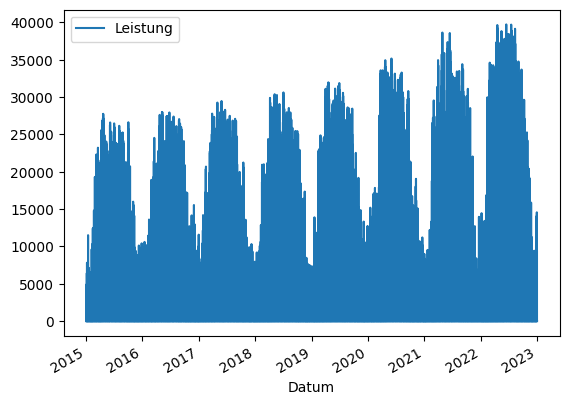

In [27]:
# Setup
solar_ts = pd.read_csv("data/energy_charts.csv", sep=",", header=0)
solar_ts["Datum"] = pd.to_datetime(solar_ts["Datum"], utc=True)

# Split
train_ts = solar_ts[solar_ts["Datum"] < "2023-01-01"]
val_ts = solar_ts[(solar_ts["Datum"] >= "2023-01-01") & (solar_ts["Datum"] < "2024-01-01")]
test_ts = solar_ts[solar_ts["Datum"] >= "2024-01-01"]

train_ts = train_ts.set_index(keys="Datum", drop=True)
val_ts = val_ts.set_index(keys="Datum", drop=True)
test_ts = test_ts.set_index(keys="Datum", drop=True)

train_ts.plot()

In [28]:
# Overview
# train_ts.info()
# train_ts.describe()
# train_ts.tail()
# train_ts.head(70)

In [29]:
# Define the function to adjust day of the year accounting for leap years
def adjust_dayofyear(row):
    date = row["Datum"] 
    adjusted_day = date.dayofyear
    if date.is_leap_year and date.dayofyear > 59:  # Check for leap year and adjust the day of the year
        adjusted_day -= 1
    return pd.Series({"adjusted_dayofyear": adjusted_day, "month": date.month})

# Apply function
train_ts = train_ts.reset_index()  # Reset index if the date is the index
new_columns = train_ts.apply(adjust_dayofyear, axis=1)
train_ts["adjusted_dayofyear"] = new_columns["adjusted_dayofyear"]
train_ts["month"] = new_columns["month"]

# Re-establishing "Datum" as index 
train_ts.set_index('Datum', inplace=True)

# Pivot table 
pv = pd.pivot_table(
    train_ts, 
    index=["month", "adjusted_dayofyear"], 
    columns=train_ts.index.year,
    values="Leistung", 
    aggfunc="sum"
)

# Check unique days in the pivot table
unique_days = sorted(pv.index.get_level_values("adjusted_dayofyear").unique())
print("Unique days in the dataset:", unique_days)

Unique days in the dataset: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

# Plot Years


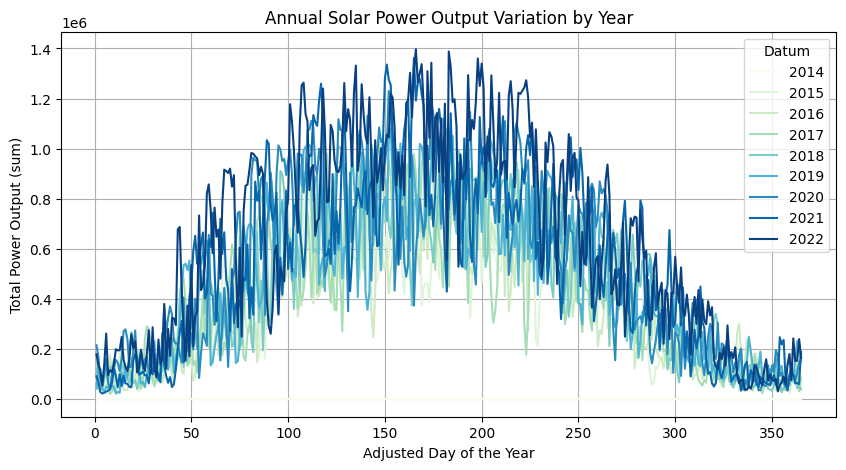

In [41]:
# Plotting for the entire year
pv_year = pv.groupby("adjusted_dayofyear").sum()

# Plotting
pv_year.plot(figsize=(10, 5), colormap = "GnBu")
plt.title("Annual Solar Power Output Variation by Year")
plt.xlabel("Adjusted Day of the Year")
plt.ylabel("Total Power Output (sum)")
plt.grid(True)

plt.show()

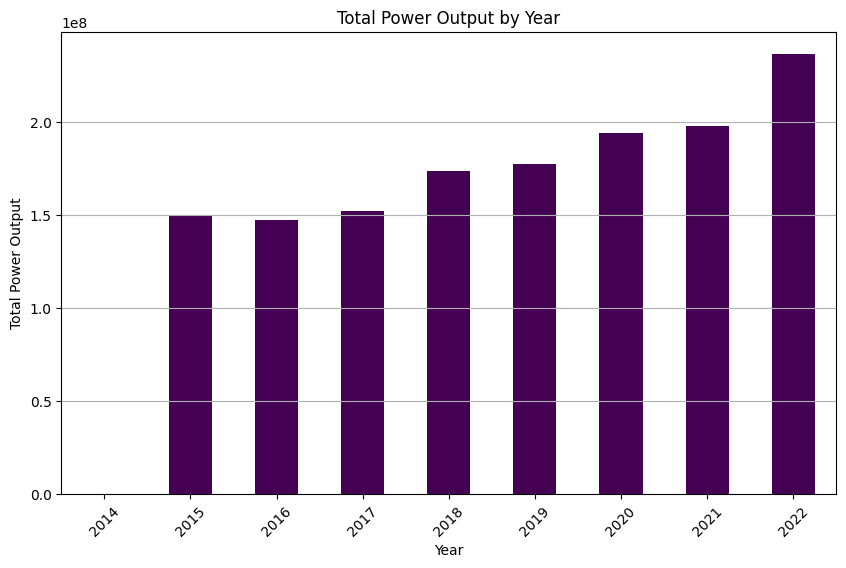

In [31]:
# Totals Plot
# Summing the values for each year
yearly_sum = pv.sum()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
yearly_sum.plot(kind='bar', colormap='viridis')
plt.title('Total Power Output by Year')
plt.xlabel('Year')
plt.ylabel('Total Power Output')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Plot Months

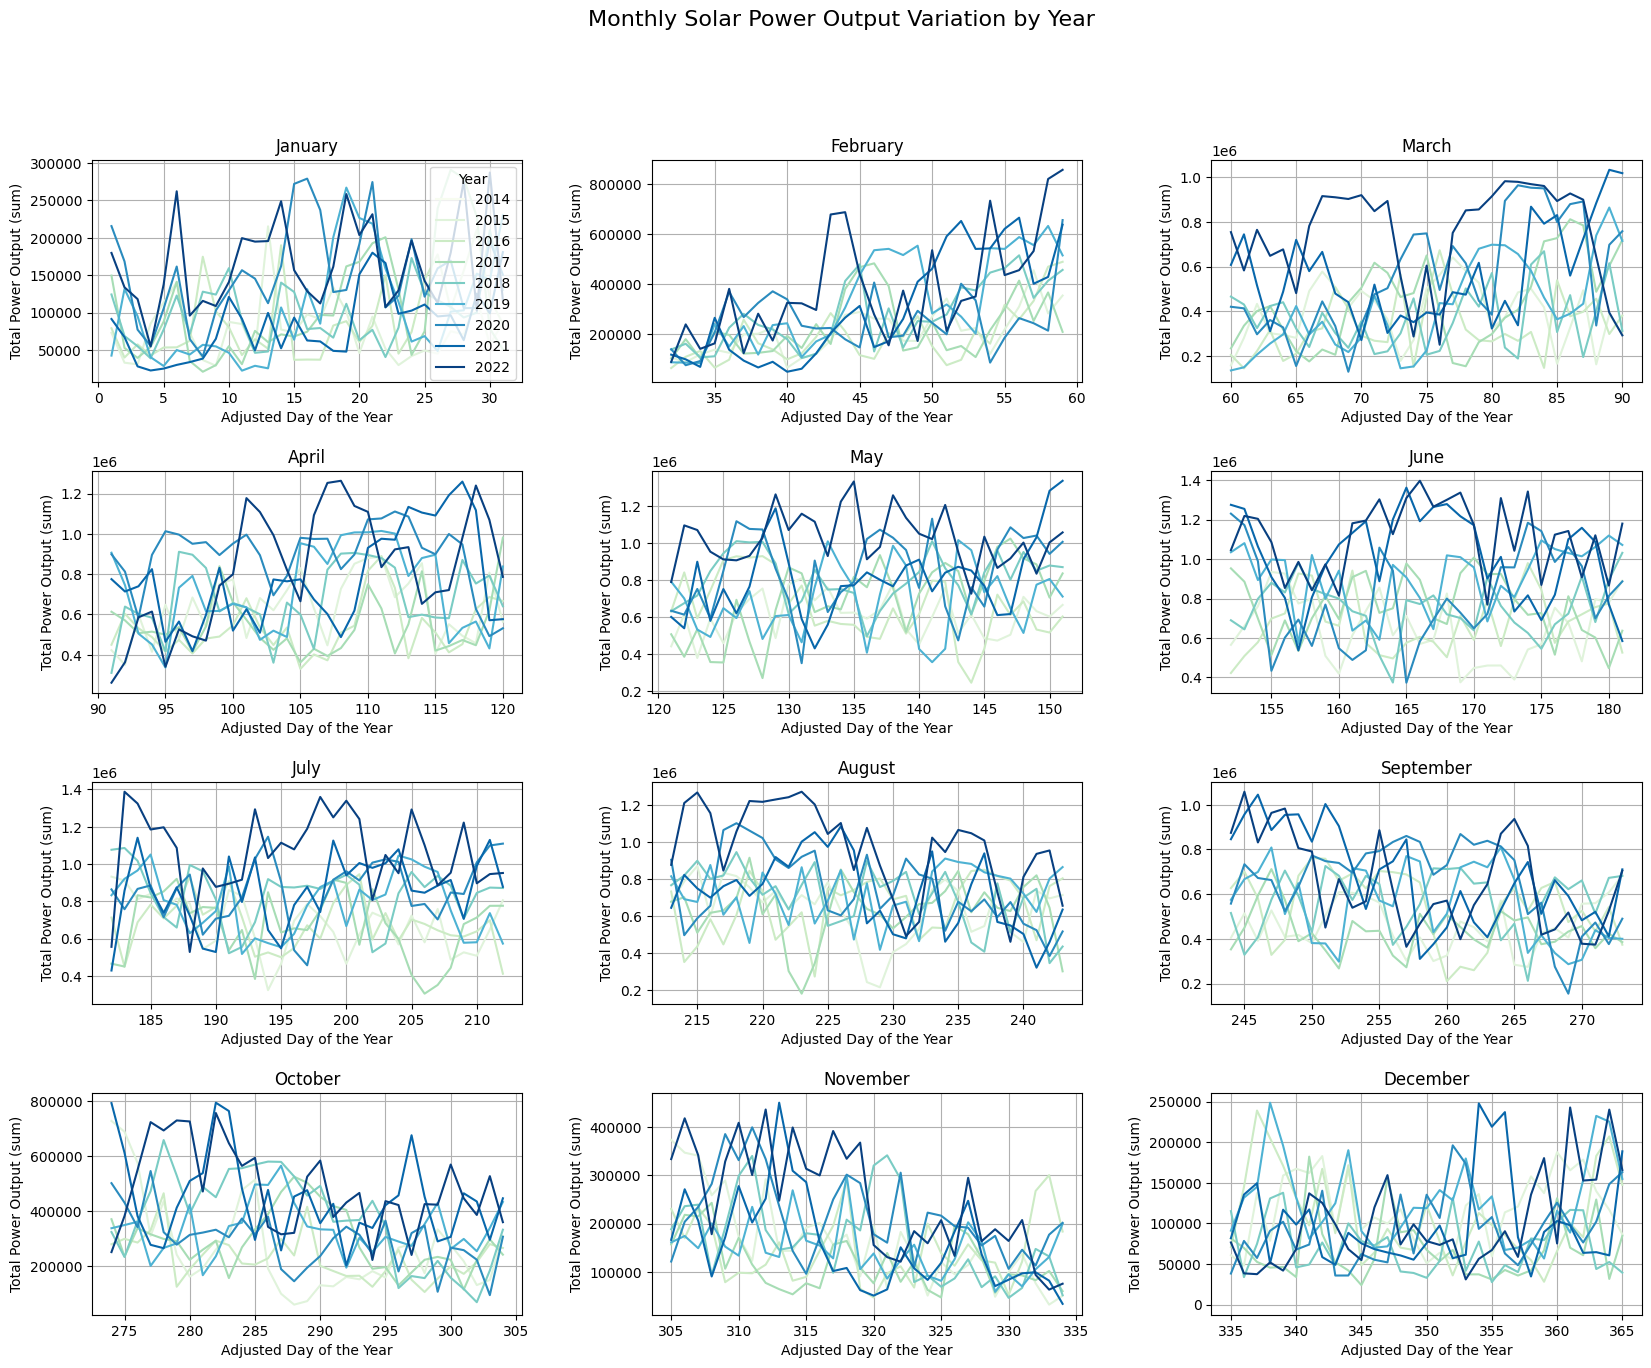

In [32]:
# Create a figure and set of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
fig.suptitle("Monthly Solar Power Output Variation by Year", fontsize=16)

# Adjust layout
plt.subplots_adjust(hspace=0.4, wspace=0.3)

months = range(1, 13)  # Months from January (1) to December (12)
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
cmap = plt.get_cmap("GnBu")  # Using GnBu colormap

for i, month in enumerate(months):
    ax = axes[i//3, i%3]
    pv_month = pv.xs(month, level="month")
    years = pv_month.columns
    colors = cmap(np.linspace(0, 1, len(years)))

    # Plot each year with a specific color from the GnBu colormap
    for j, year in enumerate(years):
        pv_month[year].plot(ax=ax, color=colors[j], label=year)

    ax.set_title(month_names[i])
    ax.set_xlabel("Adjusted Day of the Year")
    ax.set_ylabel("Total Power Output (sum)")
    ax.grid(True)
    if i == 0:  # Only add legend to the first subplot for clarity
        ax.legend(title="Year")

# Show the plot
plt.show()


Days in June data: 152 to 181


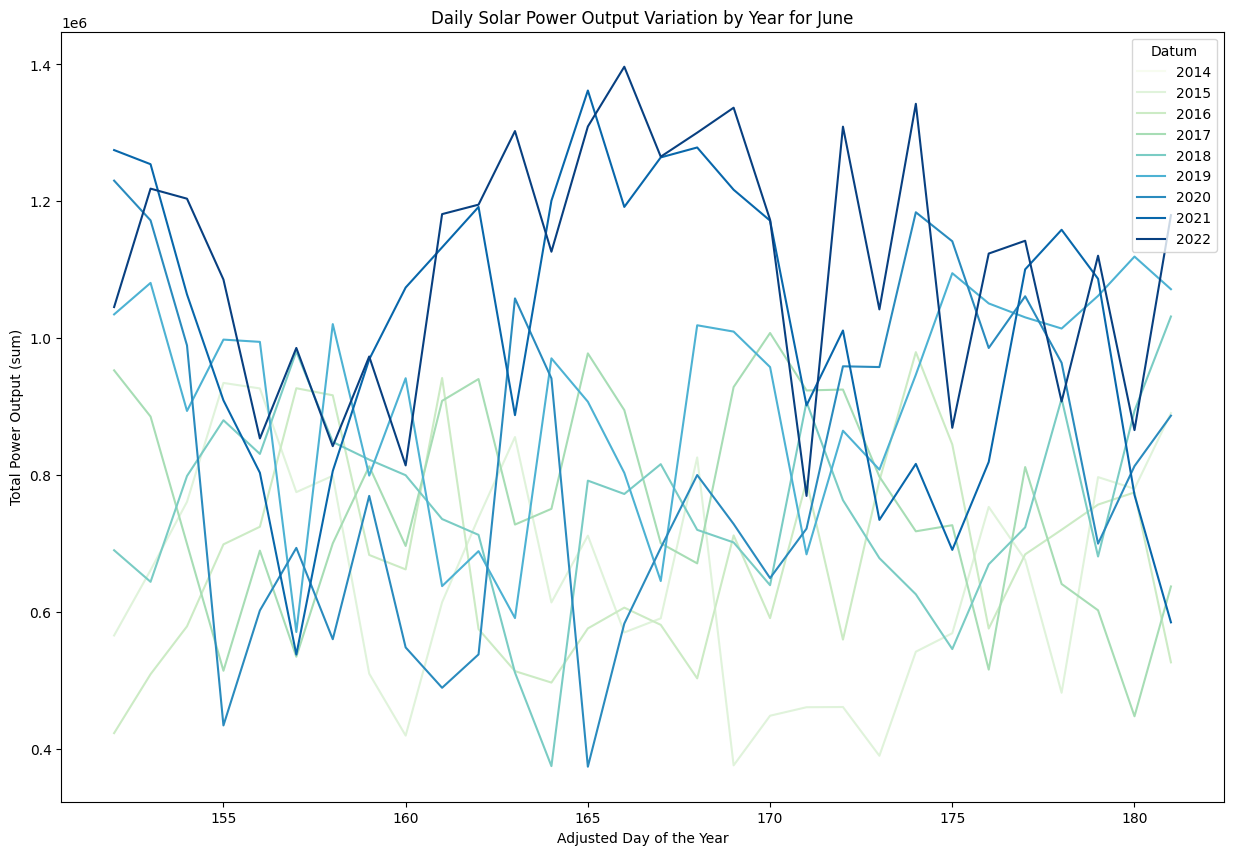

In [33]:
# Plot Months
month_to_plot = 6  # June

# Extracting data for June
pv_month = pv.xs(month_to_plot, level="month")

# Checking the days covered in June
print("Days in June data:", pv_month.index.min(), "to", pv_month.index.max())

# Plotting
pv_month.plot(figsize=(15, 10), colormap = "GnBu")
plt.title("Daily Solar Power Output Variation by Year for June")
plt.xlabel("Adjusted Day of the Year")
plt.ylabel("Total Power Output (sum)")
plt.show()

# Plot Days


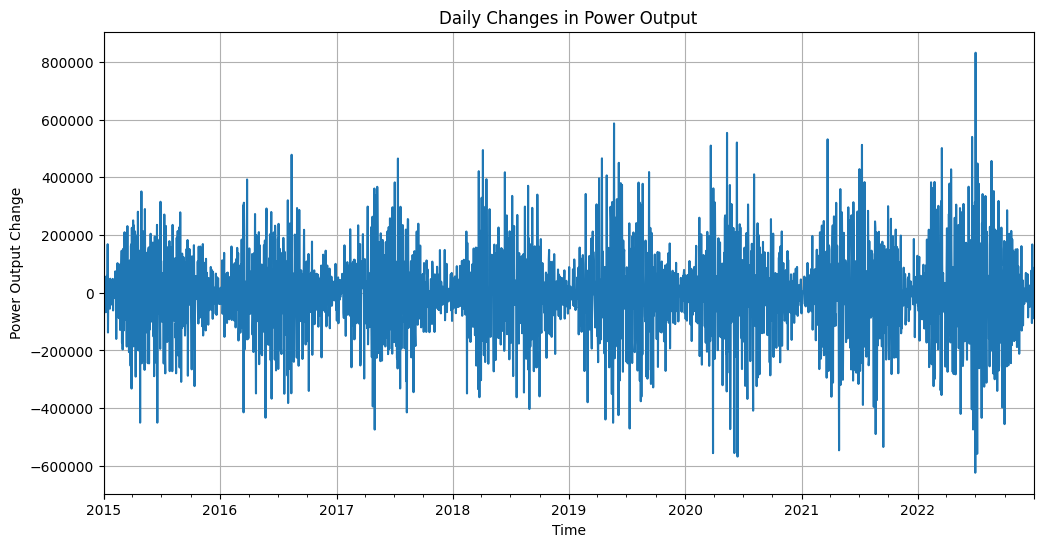

In [34]:
# Resample the data to daily frequency
daily_data = train_ts.resample('D').sum()

# Calculate the daily changes
daily_changes = daily_data.diff()

# Plot the daily changes
plt.figure(figsize=(12, 6))
daily_changes['Leistung'].plot()
plt.title('Daily Changes in Power Output')
plt.xlabel('Time')
plt.ylabel('Power Output Change')
plt.grid(True)
plt.show()


# Plot Hours


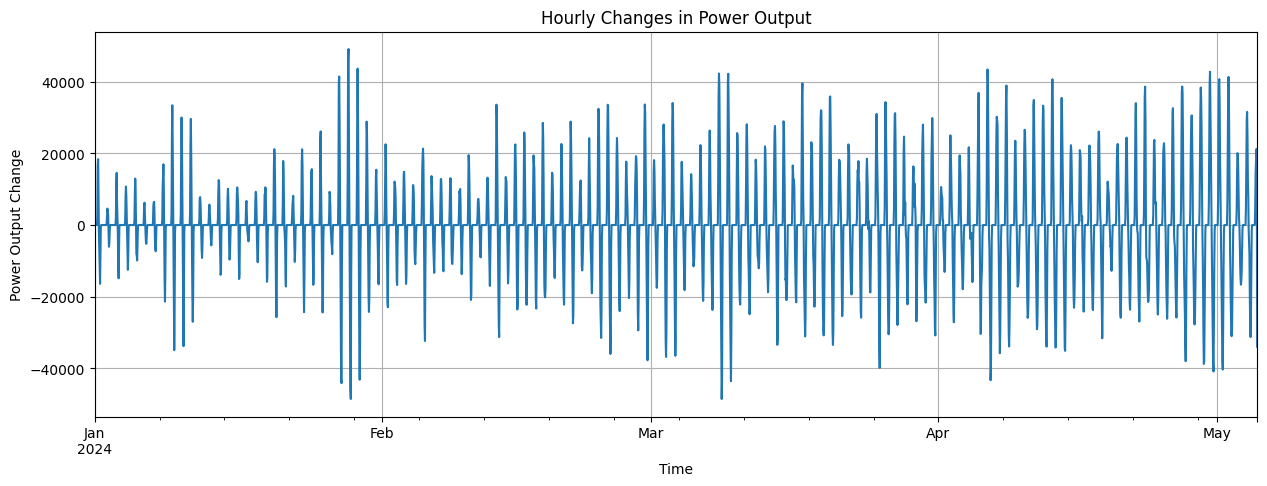

In [35]:
# Resample the data to hourly frequency
hourly_data = test_ts.resample('h').sum()

# Calculate the hourly changes
hourly_changes = hourly_data.diff()

# Plot the daily changes
plt.figure(figsize=(15, 5))
hourly_changes['Leistung'].plot()
plt.title('Hourly Changes in Power Output')
plt.xlabel('Time')
plt.ylabel('Power Output Change')
plt.grid(True)
plt.show()

Average Power Output per Hour (All Years):
           Leistung  adjusted_dayofyear     month
Datum                                            
0          0.007446          183.040942  6.526441
1          0.007495          182.915127  6.522930
2          0.354924          182.961843  6.526298
3         46.163456          182.658811  6.513661
4        466.322690          182.915127  6.522930
5       1838.593378          182.915127  6.522930
6       4469.981579          182.915127  6.522930
7       8032.620748          182.915127  6.522930
8      11683.286910          182.915127  6.522930
9      14478.806520          182.915127  6.522930
10     16022.132837          182.915127  6.522930
11     16254.258342          182.915127  6.522930
12     15236.863184          182.915127  6.522930
13     13026.490400          182.915127  6.522930
14      9835.820474          182.915127  6.522930
15      6255.450856          182.915127  6.522930
16      3149.057367          182.915127  6.522930
17     

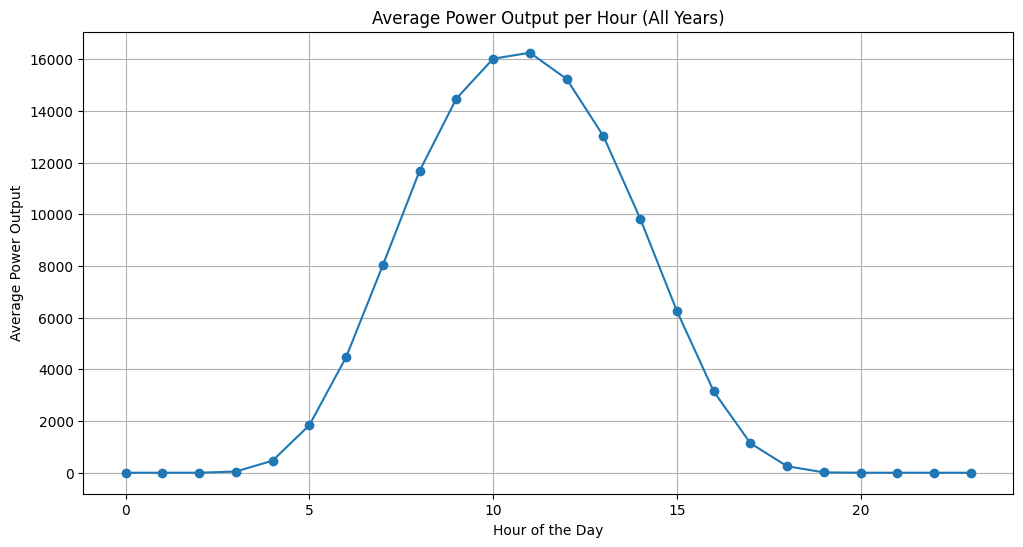

In [36]:
# Group the data by the hour of the day and calculate the mean for each hour
avg_power_per_hour = train_ts.groupby(train_ts.index.hour).mean()

# Print the average power output per hour as a table
print("Average Power Output per Hour (All Years):")
print(avg_power_per_hour)


# Plot the average power output per hour
plt.figure(figsize=(12, 6))
plt.plot(avg_power_per_hour.index, avg_power_per_hour['Leistung'], marker='o', linestyle='-')
plt.title('Average Power Output per Hour (All Years)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Power Output')
plt.grid(True)
plt.show()


# Data Cleaning


In [37]:
# Check for duplicates
duplicates = train_ts[train_ts.index.duplicated()]
print("Duplicate entries:")
print(duplicates)

# Check for missing values
missing_values = train_ts[train_ts.isnull().any(axis=1)]
print("\nMissing values:")
print(missing_values)

# Check for anomalies in the index (e.g., missing days)
# First, create a reference index covering the entire date range
reference_index = pd.date_range(start=train_ts.index.min(), end=train_ts.index.max())
missing_dates = reference_index.difference(train_ts.index)
print("\nMissing dates:")
print(missing_dates)

Duplicate entries:
                           Leistung  adjusted_dayofyear  month
Datum                                                         
2015-03-01 00:00:00+00:00       0.0                  60      3
2015-03-01 00:15:00+00:00       0.0                  60      3
2015-03-01 00:30:00+00:00       0.0                  60      3
2015-03-01 00:45:00+00:00       0.0                  60      3
2015-09-25 00:00:00+00:00       0.0                 268      9
...                             ...                 ...    ...
2022-02-27 03:45:00+00:00       0.0                  58      2
2022-09-30 00:00:00+00:00       0.0                 273      9
2022-09-30 00:15:00+00:00       0.0                 273      9
2022-09-30 00:30:00+00:00       0.0                 273      9
2022-09-30 00:45:00+00:00       0.0                 273      9

[64 rows x 3 columns]

Missing values:
Empty DataFrame
Columns: [Leistung, adjusted_dayofyear, month]
Index: []

Missing dates:
DatetimeIndex(['2015-02-28 23:00:

# Plot Anomalies


In [38]:
# Function to plot the affected observation along with the surrounding observations
def plot_anomaly_with_neighbors(anomaly_index, data):
    # Extract the subset of data containing the affected observation and its neighbors
    subset = data.iloc[anomaly_index - 3: anomaly_index + 4]
    
    # Print the subset of data
    print(subset)
    
    # Plot the subset
    plt.figure(figsize=(12, 6))
    plt.plot(subset.index, subset['Leistung'], marker='o', linestyle='-')
    plt.title(f'Power Output Time Series - Anomaly at {subset.index[3]}')
    plt.xlabel('Time')
    plt.ylabel('Power Output')
    plt.grid(True)
    plt.show()


# Function to find the nearest index
def find_nearest_index(date, index):
    min_diff = float('inf')
    nearest_index = None
    for i, idx in enumerate(index):
        diff = abs((idx - date).total_seconds())
        if diff < min_diff:
            min_diff = diff
            nearest_index = i
    return nearest_index

# Get the missing dates as anomaly indices
anomaly_indices = []
for date in missing_dates:
    nearest_index = find_nearest_index(date, train_ts.index)
    anomaly_indices.append(nearest_index)

# Plot the affected observation along with the surrounding observations for each anomaly
# for anomaly_index in anomaly_indices:
#     plot_anomaly_with_neighbors(anomaly_index, train_ts)


# Aggregate to Hourly

In [39]:
train_hours = train_ts.resample("h").sum() # Aggregate to Hourly (Sum)
train_hours = train_hours.interpolate(method = "time") # Interpolate
train_hours = train_hours.asfreq(pd.infer_freq(train_hours.index)) # Infer Frequency

In [42]:
np.count_nonzero(train_hours.index.duplicated())

0